# Updated code

In [13]:
import pandas as pd
from pathlib import Path
import logging
import sys
from tqdm.auto import tqdm

# =========================================================================
# 0. CONFIGURATION & SETUP
# =========================================================================

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Paths
data_dir = Path("./data/company_data_processed")

OUTPUT_DIR_CLEAN = Path("./data/seniority_DWA_data_CLEAN")
OUTPUT_DIR_CLEAN.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR_TOTALS = Path("./data/firm_level_totals") 
OUTPUT_DIR_TOTALS.mkdir(parents=True, exist_ok=True)

parquet_files_processed_RAW = list(data_dir.glob("*.parquet"))

# Constants and Parameters
COLS = ["firm_id", "dwa_id", "month", "seniority", "FTE"]
SENIORITY_GROUPS = [[1], [2], [3], [4], [5], [6], [7]]

PRE_START = '2021-01-01'
PRE_END = '2022-10-01'
TAU_FIRMS = 25       # Minimum unique firms (Strictly Continuous)
TAU_MASS_PCT = 0.001 # Minimum mass share percentage

# Pre-calculations
SENIORITY_MAP = {raw_val: tuple(group) for group in SENIORITY_GROUPS for raw_val in group}

# =========================================================================
# 1. CORE PIPELINE FUNCTIONS
# =========================================================================

def load_and_prepare_data(file_list):
    logger.info(f"--- 1. Loading and Preparation (Brynjolfsson Firm-Level Balance) ---")
    all_frames = []
    
    for file_path in tqdm(file_list, desc="Loading Parquet Files"):
        try:
            df = pd.read_parquet(file_path, columns=COLS)
            df["month"] = pd.to_datetime(df["month"])
            all_frames.append(df)
        except Exception as e:
            logger.warning(f"Skipping file: {file_path}: {e}")
            
    if not all_frames: return None, None, None
        
    print("Concatenating...")
    df_master = pd.concat(all_frames, ignore_index=True)
    df_master = df_master.dropna(subset=COLS).copy()
    
    # --- ANGRIST FIX: STRICT WINDOW FILTERING ---
    # 1. First, throw away any data outside the study window.
    #    This prevents "phantom months" from breaking the balance check.
    mask_window = (df_master['month'] >= PRE_START) & (df_master['month'] <= PRE_END)
    df_master = df_master[mask_window].copy()
    
    # 2. Filter for Heartbeat (Activity)
    df_master = df_master[df_master['FTE'] > 0].copy()

    # 3. Identify firms present in EVERY month of the TARGET WINDOW
    #    We use the theoretical range to be safe, or the data's range after filtering.
    target_months = pd.date_range(start=PRE_START, end=PRE_END, freq='MS')
    required_count = len(target_months)
    
    firm_counts = df_master.groupby('firm_id')['month'].nunique()
    balanced_firms = firm_counts[firm_counts == required_count].index
    
    print(f"Filtering for Balanced Firms: Keeping {len(balanced_firms):,} out of {len(firm_counts):,} firms.")
    df_master = df_master[df_master['firm_id'].isin(balanced_firms)].copy()
    
    # 4. Calculate Totals on this clean, balanced set
    print("Calculating Firm Totals (Balanced Panel)...")
    total_fte_per_firm_month = df_master.groupby(['firm_id', 'month'])['FTE'].sum().reset_index()
    total_fte_per_firm_month = total_fte_per_firm_month.rename(columns={'FTE': 'firm_month_total_fte_all'})
    
    print("Calculating Seniority Totals...")
    total_fte_per_seniority = df_master.groupby(['firm_id', 'month', 'seniority'])['FTE'].sum().reset_index()
    total_fte_per_seniority = total_fte_per_seniority.rename(columns={'FTE': 'firm_seniority_total_fte'})

    df_master['group_key'] = df_master['seniority'].map(SENIORITY_MAP)
    
    return df_master, total_fte_per_firm_month, total_fte_per_seniority

def validate_dwa_continuity(df_master):
    logger.info(f"--- 2. DWA Validation (Relevance Only) ---")
    
    # Focus on the Pre-Period for selection
    df_pre = df_master[
        (df_master['month'] >= PRE_START) & 
        (df_master['month'] <= PRE_END)
    ].copy()
    
    # --- ANGRIST FIX: REMOVE SURVIVOR FILTER ---
    # We only care if the task is "Relevant" (has enough mass in the economy).
    # We do NOT require it to survive in specific firms.
    
    relevance_stats = df_pre.groupby(['group_key', 'dwa_id'])['FTE'].sum().reset_index(name='total_pre_period_fte')
    group_total_ftes = df_pre.groupby('group_key')['FTE'].sum().to_dict()

    valid_tasks_map = []

    for group_list in SENIORITY_GROUPS:
        group_key = tuple(group_list)
        
        # Get all tasks for this seniority
        candidate_tasks = relevance_stats[relevance_stats['group_key'] == group_key].copy()
        
        # Calculate Mass Share
        total_group_fte = group_total_ftes.get(group_key, 0)
        if total_group_fte > 0:
            candidate_tasks['mass_share'] = (candidate_tasks['total_pre_period_fte'] / total_group_fte) * 100
        else:
            candidate_tasks['mass_share'] = 0
            
        # Filter: Keep if it makes up > 0.001% of the seniority group's labor
        valid_tasks = candidate_tasks[candidate_tasks['mass_share'] >= TAU_MASS_PCT]
        
        for dwa in valid_tasks['dwa_id']:
            valid_tasks_map.append({'group_key': group_key, 'dwa_id': dwa})
            
        logger.info(f"Group {group_key}: {len(valid_tasks)} tasks selected (Based on Mass Share).")

    df_valid_tasks = pd.DataFrame(valid_tasks_map)
    return valid_tasks_map, df_valid_tasks


def extract_and_save_data(df_master, total_fte_df, df_valid_tasks):
    logger.info("--- 3. Data Extraction (Pass 2: Unbalanced Panel) ---")
    
    # 1. Filter Master Data by VALID TASKS only (Keep all firms)
    df_master_clean = df_master.merge(
        df_valid_tasks,
        on=['group_key', 'dwa_id'],
        how='inner'
    )
    
    logger.info(f"Master rows (All Firms) for Valid Tasks: {len(df_master_clean):,}")
    
    # 2. Separate and Save
    for level in SENIORITY_GROUPS:
        key = tuple(level)
        group_name = "_".join(map(str, level))
        
        df_group_subset = df_master_clean[df_master_clean['group_key'] == key].copy()
        
        # FINAL CLEANING: Only save rows with positive FTE
        filtered_subset = df_group_subset[df_group_subset["FTE"] > 0] 
        
        if not filtered_subset.empty:
            filtered_subset = filtered_subset.merge(total_fte_df, on=['firm_id', 'month'], how='left')
            filtered_subset.dropna(subset=['firm_month_total_fte_all'], inplace=True)
            
            output_path = OUTPUT_DIR_CLEAN / f"seniority_{group_name}_data.parquet"
            filtered_subset.to_parquet(output_path, index=False, compression="snappy")
            logger.info(f"Saved: {output_path} (Rows: {len(filtered_subset):,})")
        else:
            logger.warning(f"Group {group_name}: Filtered data is empty. Nothing saved.")


# =========================================================================
# 4. EXECUTION COORDINATOR
# =========================================================================

def main_pipeline_execution(file_list):
    # 1. LOAD AND PREPARE
    df_master, total_fte_df, total_seniority_df = load_and_prepare_data(file_list)
    if df_master is None:
        return None

    # --- SAVE GLOBAL TOTALS TO NEW FOLDER ---
    # Use the new OUTPUT_DIR_TOTALS path defined in config
    totals_path = OUTPUT_DIR_TOTALS / "firm_month_totals.parquet"
    logger.info(f"Saving Firm Totals to: {totals_path}")
    total_fte_df.to_parquet(totals_path, index=False)

    # --- SAVE SENIORITY TOTALS TO NEW FOLDER ---
    seniority_totals_path = OUTPUT_DIR_TOTALS / "firm_seniority_totals.parquet"
    logger.info(f"Saving Seniority Totals to: {seniority_totals_path}")
    total_seniority_df.to_parquet(seniority_totals_path, index=False)
    # -----------------------------------------

    # 2. VALIDATION (Pass 1)
    valid_tasks_map, df_valid_tasks = validate_dwa_continuity(df_master)
    
    if df_valid_tasks.empty:
        logger.error("Stopping pipeline.")
        return None

    # 3. EXTRACTION (Pass 2)
    extract_and_save_data(df_master, total_fte_df, df_valid_tasks)
    
    return valid_tasks_map

# --- MAIN EXECUTION ---

logger.info(f"Using {len(parquet_files_processed_RAW)} parquet files for processing.")
logger.info("\n*** STARTING FUNCTIONAL UNIFIED DATA PIPELINE (ANGRIST METHOD) ***\n")

# Clear old functions
try:
    del sys.modules[__name__].get_valid_ids_per_group
    del sys.modules[__name__].process_with_group_masks
except:
    pass

# Run the main coordinator
final_valid_map = main_pipeline_execution(parquet_files_processed_RAW)

# --- SUMMARY ---
if final_valid_map:
    print("\n" + "=" * 50)
    print("✅ PIPELINE COMPLETED: VALIDATION SUMMARY")
    print("=" * 50)
    
    df_summary = pd.DataFrame(final_valid_map)
    counts = df_summary.groupby('group_key')['dwa_id'].nunique()
    
    print("--- Validated Task Counts per Seniority Group ---")
    for group_key, count in counts.items():
        print(f"Seniority Level {group_key} : {count:>6,} valid tasks")

2025-12-08 23:34:29,766 - INFO - Using 4092 parquet files for processing.
2025-12-08 23:34:29,767 - INFO - 
*** STARTING FUNCTIONAL UNIFIED DATA PIPELINE (ANGRIST METHOD) ***

2025-12-08 23:34:29,768 - INFO - --- 1. Loading and Preparation (Brynjolfsson Firm-Level Balance) ---
Loading Parquet Files: 100%|██████████| 4092/4092 [00:34<00:00, 120.14it/s]


Concatenating...
Filtering for Balanced Firms: Keeping 3,999 out of 4,045 firms.
Calculating Firm Totals (Balanced Panel)...
Calculating Seniority Totals...


2025-12-08 23:36:26,435 - INFO - Saving Firm Totals to: data/firm_level_totals/firm_month_totals.parquet
2025-12-08 23:36:26,447 - INFO - Saving Seniority Totals to: data/firm_level_totals/firm_seniority_totals.parquet
2025-12-08 23:36:26,484 - INFO - --- 2. DWA Validation (Relevance Only) ---
2025-12-08 23:36:54,373 - INFO - Group (1,): 1664 tasks selected (Based on Mass Share).
2025-12-08 23:36:54,374 - INFO - Group (2,): 1674 tasks selected (Based on Mass Share).
2025-12-08 23:36:54,376 - INFO - Group (3,): 1571 tasks selected (Based on Mass Share).
2025-12-08 23:36:54,378 - INFO - Group (4,): 1493 tasks selected (Based on Mass Share).
2025-12-08 23:36:54,380 - INFO - Group (5,): 1393 tasks selected (Based on Mass Share).
2025-12-08 23:36:54,381 - INFO - Group (6,): 1072 tasks selected (Based on Mass Share).
2025-12-08 23:36:54,383 - INFO - Group (7,): 997 tasks selected (Based on Mass Share).
2025-12-08 23:36:55,086 - INFO - --- 3. Data Extraction (Pass 2: Unbalanced Panel) ---
202


✅ PIPELINE COMPLETED: VALIDATION SUMMARY
--- Validated Task Counts per Seniority Group ---
Seniority Level (1,) :  1,664 valid tasks
Seniority Level (2,) :  1,674 valid tasks
Seniority Level (3,) :  1,571 valid tasks
Seniority Level (4,) :  1,493 valid tasks
Seniority Level (5,) :  1,393 valid tasks
Seniority Level (6,) :  1,072 valid tasks
Seniority Level (7,) :    997 valid tasks


🎯 Target: Firms must have 57 months to survive the Balanced Panel filter.
Found 4092 files. Scanning firm lifespans...


Scanning Firms: 100%|██████████| 4092/4092 [00:46<00:00, 87.30it/s] 



💀 MORTALITY REPORT
Total Firms Scanned:   4,064
Survivor Threshold:    57 months
Survivors (Balanced):  3,986 (98.1%)
Casualties (Dropped):  78 (191.9%)
----------------------------------------
Avg Lifespan:          56.4 months
Median Lifespan:       57.0 months


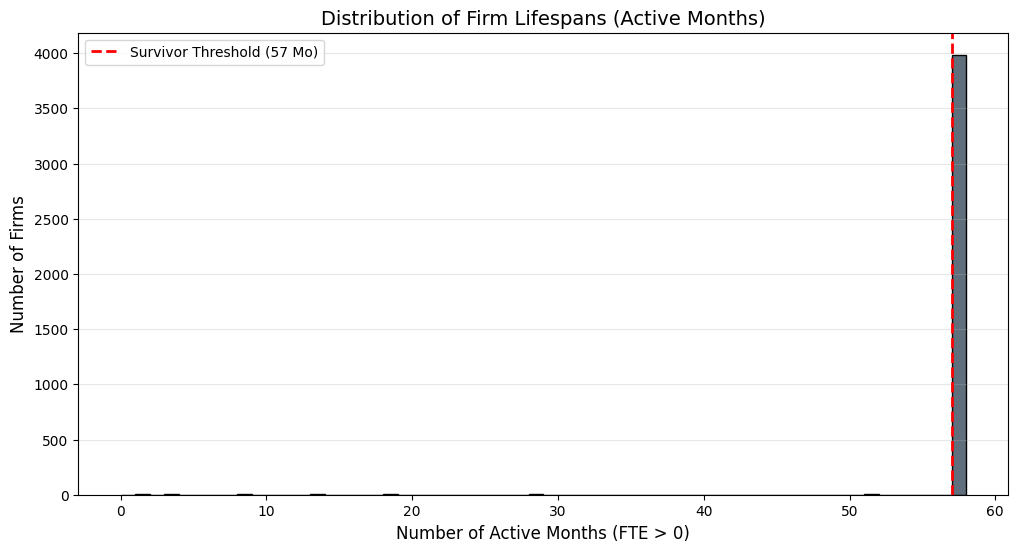

In [14]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# =========================================================================
# CONFIGURATION
# =========================================================================
INPUT_DIR = Path("./data/company_data_processed")
FILES_PATTERN = "*.parquet"

# Define the full study window (for comparison)
START_DATE = '2021-01-01'
END_DATE = '2025-09-01'
EXPECTED_MONTHS = len(pd.date_range(start=START_DATE, end=END_DATE, freq='MS'))

print(f"🎯 Target: Firms must have {EXPECTED_MONTHS} months to survive the Balanced Panel filter.")

# =========================================================================
# EXECUTION
# =========================================================================

firm_lifespans = {}

files = list(INPUT_DIR.glob(FILES_PATTERN))
print(f"Found {len(files)} files. Scanning firm lifespans...")

for file_path in tqdm(files, desc="Scanning Firms"):
    try:
        # Load only necessary columns to save memory
        df = pd.read_parquet(file_path, columns=['firm_id', 'month', 'FTE'])
        
        # Ensure date format
        df['month'] = pd.to_datetime(df['month'])
        
        # Filter for the study window (strictly what the pipeline sees)
        df = df[(df['month'] >= START_DATE) & (df['month'] <= END_DATE)]
        
        # Filter for actual activity (Heartbeat check)
        df = df[df['FTE'] > 0]
        
        if df.empty:
            continue

        # Count unique months per firm in this file
        # Note: If firms are split across files, we need to aggregate differently.
        # Assuming firms are NOT split across files (standard for this type of data),
        # or we simply update the dict.
        counts = df.groupby('firm_id')['month'].nunique()
        
        for firm_id, count in counts.items():
            # If firm exists in multiple files, we take the max or sum? 
            # Usually safe to assume we just want the set of months.
            # A safer, slightly slower way for split files:
            if firm_id not in firm_lifespans:
                firm_lifespans[firm_id] = set()
            
            # Add the unique months found in this chunk
            firm_months = df[df['firm_id'] == firm_id]['month'].unique()
            firm_lifespans[firm_id].update(firm_months)
            
    except Exception as e:
        print(f"⚠️ Error reading {file_path.name}: {e}")

# Convert sets to counts
final_counts = [len(months) for months in firm_lifespans.values()]

# =========================================================================
# VISUALIZATION
# =========================================================================

if not final_counts:
    print("❌ No valid firm data found.")
else:
    plt.figure(figsize=(12, 6))
    
    # Histogram
    sns.histplot(final_counts, bins=range(0, EXPECTED_MONTHS + 2), kde=False, color='#2c3e50')
    
    # Reference Line (The Survivor Cutoff)
    plt.axvline(EXPECTED_MONTHS, color='red', linestyle='--', linewidth=2, label=f'Survivor Threshold ({EXPECTED_MONTHS} Mo)')
    
    plt.title('Distribution of Firm Lifespans (Active Months)', fontsize=14)
    plt.xlabel('Number of Active Months (FTE > 0)', fontsize=12)
    plt.ylabel('Number of Firms', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Stats Summary
    total_firms = len(final_counts)
    survivors = sum(1 for c in final_counts if c == EXPECTED_MONTHS)
    dropout_rate = 100 * (1 - survivors / total_firms)
    
    print("\n" + "="*40)
    print("💀 MORTALITY REPORT")
    print("="*40)
    print(f"Total Firms Scanned:   {total_firms:,}")
    print(f"Survivor Threshold:    {EXPECTED_MONTHS} months")
    print(f"Survivors (Balanced):  {survivors:,} ({survivors/total_firms:.1%})")
    print(f"Casualties (Dropped):  {total_firms - survivors:,} ({dropout_rate:.1%})")
    print("-" * 40)
    print(f"Avg Lifespan:          {sum(final_counts)/total_firms:.1f} months")
    print(f"Median Lifespan:       {pd.Series(final_counts).median():.1f} months")
    print("="*40)
    
    plt.show()